In [39]:
import csv
from matplotlib import pyplot as plt
import numpy as np
from scipy.misc import imread
import pickle
import cv2
import seaborn as sns
import warnings
from jupyterthemes import jtplot

In [40]:
%matplotlib inline
jtplot.style()
sns.set_context("poster")
# plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")

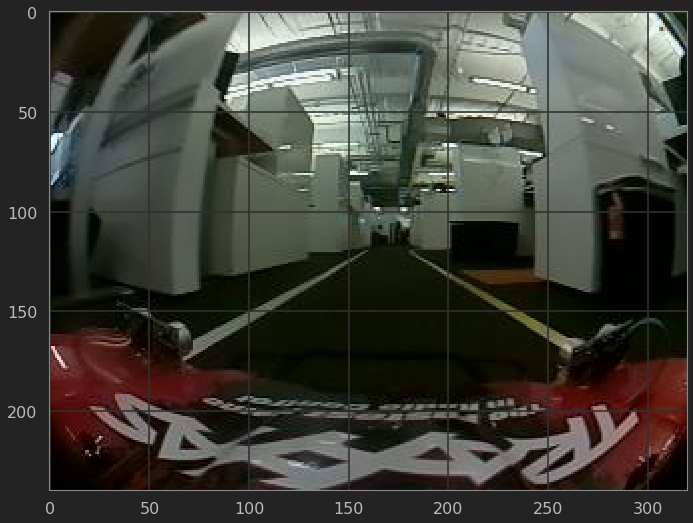

In [55]:
img = imread("data/office_2_2/100.jpg")
plt.imshow(img)


In [56]:
folder_to_process = "office_2_1"

In [43]:
# this file is used to process the raw output of recording training data from the simulator
# and prepare it for uploading to the AWS GPU


print("Processing ", folder_to_process)


def extract_data(folder):
    X = [] #images
    XX = [] #senor data (aka speed in this case)
    y = [] #actual steering angles (throttle in the future)


    with open('data/{}/_data.csv'.format(folder_to_process)) as f:
        reader = csv.reader(f)
        print(''.join(next(reader)))
        for line in reader:
            line = ''.join(line).split('|')
            img_file= "{}".format(int(line[0]))
            img = imread('data/{}/{}.jpg'.format(folder_to_process, img_file))
            
            print
            X.append(img)
            #index 8 - throttle is -100 to 100
            #index 7 - rpm is 5000ish max
            XX.append([float(line[7])/5000, float(line[8])/100]) 
            y.append([float(line[5])/45.0]) # steering is -45 to 45

    return (np.array(X), np.array(XX), np.array(y))


X_train, XX_train, y_train = extract_data(folder_to_process)

print("--done--")

Processing  office_2_1
image_id|ACC|MAG|UFL|GYR|STR|UFR|RPM|THR|PRH|time
--done--


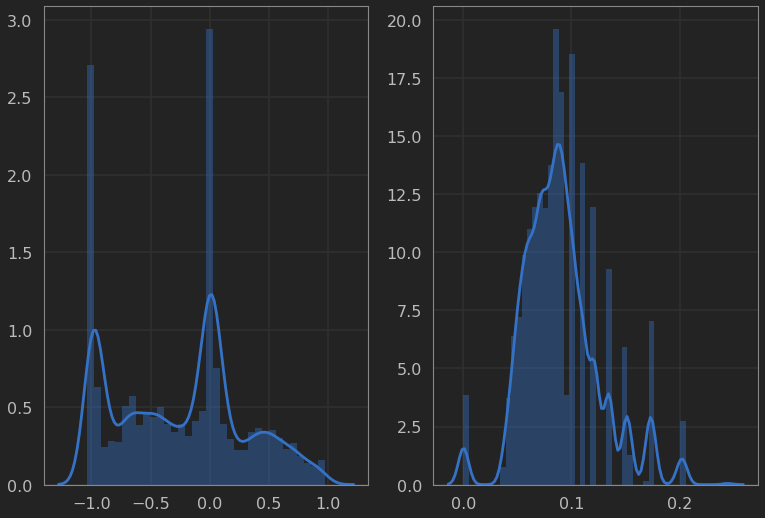

In [44]:
plt.subplot(1,2,1)
sns.distplot(y_train)
plt.subplot(1,2,2)
sns.distplot(XX_train[:,0])

In [45]:
#bring in camera calibration matrix
with open('../camera_calibration/fisheye_f1p8_camera_calibration.pkl', 'rb') as f:
    calibration = pickle.load(f)
mtx = calibration["mtx"]
dist = calibration["dist"]

with open('fisheye_f1p8_camera_calibration.pkl', 'wb') as f:
    pickle.dump(calibration, f, protocol=2)

def pipeline(image):
    #undistort it
#     undistort = cv2.undistort(image, mtx, dist, None, mtx)
    output = image[100:180,:,:]
    return  output

(240, 320, 3)


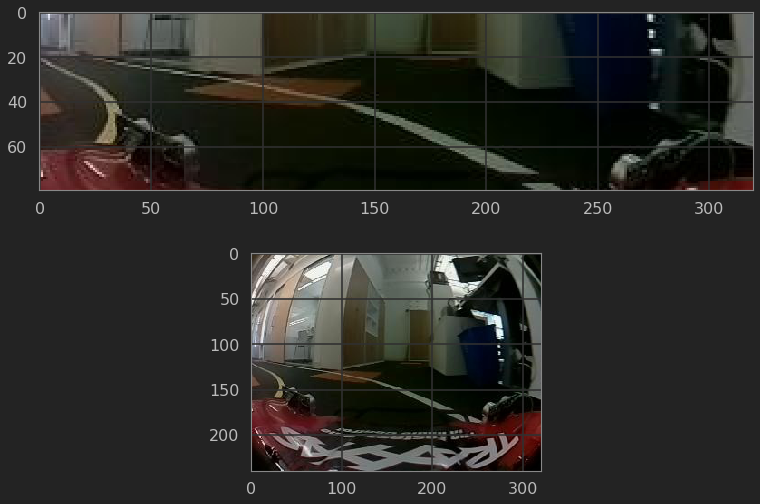

In [46]:
x = X_train[150]
print(x.shape)
plt.subplot(2,1,1)
plt.imshow(pipeline(x))
plt.subplot(2,1,2)
plt.imshow(x)

In [47]:
#reduce image to the road section and apply any transforms in the pipeline
X_train = np.array([pipeline(x) for x in X_train])

In [48]:
X_train.shape

(17323, 80, 320, 3)

In [49]:
# the following section was used to scrub through the video and find bad sections and remove them
current_frame = 100
scroll_rate = 10

Current Frame:  100 Steering [ 0.01200002] rpm [ 0.0008      0.13199997]


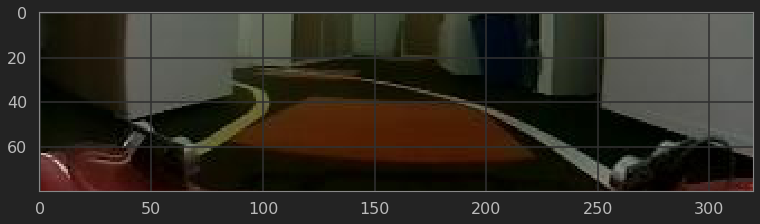

In [50]:
#scrub through thismanually for bad frames.... ouch time consuming
print("Current Frame: ", current_frame, "Steering", y_train[current_frame], "rpm", XX_train[current_frame] )
plt.imshow(X_train[current_frame])
current_frame += scroll_rate



In [51]:
#drop bad frames
## bag 1
data_frames_to_drop = [(0,200), (-300, -1)]


clean_indicies = np.ones(len(X_train))
for r in data_frames_to_drop:
    clean_indicies[r[0]:r[1]] = 0

In [52]:
X_cleaned = X_train[clean_indicies.astype(np.bool)]
XX_cleaned = XX_train[clean_indicies.astype(np.bool)]
y_cleaned = y_train[clean_indicies.astype(np.bool)]

print(X_cleaned.shape,XX_cleaned.shape, y_cleaned.shape)

data = {
    "images": X_cleaned,
    "sensors": XX_cleaned,
    "steering_throttle": y_cleaned
}

(16824, 80, 320, 3) (16824, 2) (16824, 1)


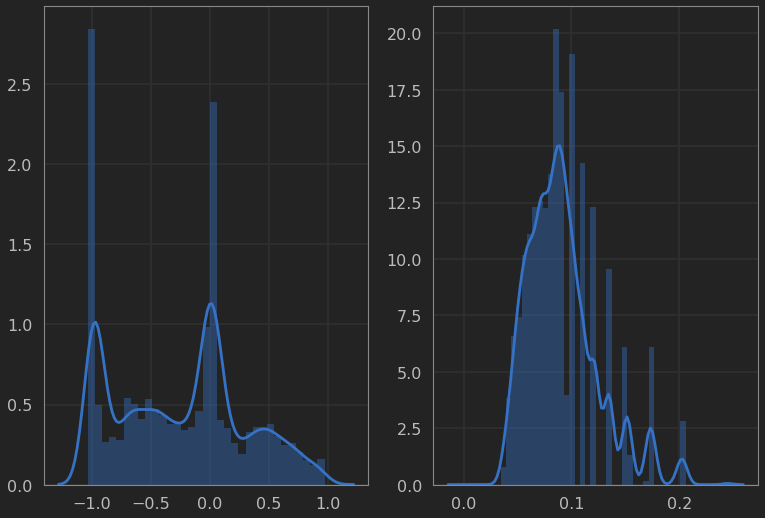

In [53]:
plt.subplot(1,2,1)
sns.distplot(y_cleaned)
plt.subplot(1,2,2)
sns.distplot(XX_cleaned[:,0])

In [54]:
with open('V79_run_{}.pkl'.format(folder_to_process), 'wb') as f:
    pickle.dump(data, f)